In [36]:
# Imports + paths

import os
from pathlib import Path
import json
import math
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from ultralytics import YOLO

# You are running from: <root>/notebooks/
ROOT = Path("").resolve()

DATA_DIR   = ROOT / "data"
VIDEOS_DIR = DATA_DIR / "videos_compressed"
OUT_DIR    = ROOT / "outputs" / "notebook6"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# YOLO weights (your 48-class best.pt)
YOLO_WEIGHTS = ROOT / "best.pt"   # change if needed
assert YOLO_WEIGHTS.exists(), f"Missing YOLO weights: {YOLO_WEIGHTS}"

# Notebook 5 outputs (stable timeline per video)
NB5_DIR = ROOT / "outputs" / "notebook5"
assert NB5_DIR.exists(), f"Missing notebook5 outputs folder: {NB5_DIR}"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("ROOT:", ROOT)
print("VIDEOS_DIR:", VIDEOS_DIR, "exists:", VIDEOS_DIR.exists())
print("YOLO_WEIGHTS:", YOLO_WEIGHTS, "exists:", YOLO_WEIGHTS.exists())
print("NB5_DIR:", NB5_DIR, "exists:", NB5_DIR.exists())
print("DEVICE:", DEVICE)
print("OUT_DIR:", OUT_DIR)

ROOT: /data/wesleyferreiramaia/workzone
VIDEOS_DIR: /data/wesleyferreiramaia/workzone/data/videos_compressed exists: True
YOLO_WEIGHTS: /data/wesleyferreiramaia/workzone/best.pt exists: True
NB5_DIR: /data/wesleyferreiramaia/workzone/outputs/notebook5 exists: True
DEVICE: cuda
OUT_DIR: /data/wesleyferreiramaia/workzone/outputs/notebook6


In [37]:
# Load YOLO + define triggers

yolo = YOLO(str(YOLO_WEIGHTS))
try:
    yolo.to(DEVICE)
except Exception:
    pass
yolo.eval()

names = yolo.names
print("Loaded YOLO weights:", YOLO_WEIGHTS)
print("Num classes:", len(names))
# print(names)

def find_class_ids_by_keyword(names_dict, keywords):
    """Return class IDs whose name contains any keyword (case-insensitive)."""
    ids = []
    for cid, cname in names_dict.items():
        low = str(cname).lower()
        if any(k.lower() in low for k in keywords):
            ids.append(cid)
    return sorted(set(ids))

# Trigger classes (based on your ROADWork naming)
TTC_SIGN_IDS = find_class_ids_by_keyword(names, ["temporary traffic control sign", "ttc sign"])
MESSAGE_BOARD_IDS = find_class_ids_by_keyword(names, ["message board"])
ARROW_BOARD_IDS = find_class_ids_by_keyword(names, ["arrow board"])

TRIGGER_CLASS_IDS = sorted(set(TTC_SIGN_IDS + MESSAGE_BOARD_IDS + ARROW_BOARD_IDS))

print("TTC_SIGN_IDS:", TTC_SIGN_IDS[:10], "..." if len(TTC_SIGN_IDS)>10 else "")
print("MESSAGE_BOARD_IDS:", MESSAGE_BOARD_IDS)
print("ARROW_BOARD_IDS:", ARROW_BOARD_IDS)
print("TRIGGER_CLASS_IDS:", TRIGGER_CLASS_IDS)

Loaded YOLO weights: /data/wesleyferreiramaia/workzone/best.pt
Num classes: 48
TTC_SIGN_IDS: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] ...
MESSAGE_BOARD_IDS: [14]
ARROW_BOARD_IDS: [9]
TRIGGER_CLASS_IDS: [9, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [38]:
# Helpers

def list_videos(videos_dir: Path, limit=None):
    vids = sorted(videos_dir.glob("*.mp4"))
    if limit is not None:
        vids = vids[:limit]
    return vids

def read_frame_at(cap, frame_idx: int):
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
    ok, frame = cap.read()
    return ok, frame

def yolo_predict_frame(frame_bgr, imgsz=960, conf=0.25, iou=0.7):
    res = yolo.predict(
        source=frame_bgr,
        imgsz=imgsz,
        conf=conf,
        iou=iou,
        verbose=False,
        device=0 if DEVICE == "cuda" else "cpu",
    )[0]
    return res

def boxes_to_rows(result, frame_w, frame_h):
    rows = []
    if result.boxes is None or len(result.boxes) == 0:
        return rows

    for b in result.boxes:
        cid = int(b.cls.item())
        conf = float(b.conf.item())
        x1, y1, x2, y2 = b.xyxy[0].tolist()

        # clamp
        x1 = max(0, min(frame_w - 1, x1))
        x2 = max(0, min(frame_w - 1, x2))
        y1 = max(0, min(frame_h - 1, y1))
        y2 = max(0, min(frame_h - 1, y2))

        rows.append({
            "cls_id": cid,
            "cls_name": names.get(cid, str(cid)),
            "conf": conf,
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "area": (x2 - x1) * (y2 - y1),
        })
    return rows

def crop_roi(frame_bgr, x1, y1, x2, y2, pad=12):
    h, w = frame_bgr.shape[:2]
    x1p = int(max(0, x1 - pad))
    y1p = int(max(0, y1 - pad))
    x2p = int(min(w - 1, x2 + pad))
    y2p = int(min(h - 1, y2 + pad))
    if x2p <= x1p or y2p <= y1p:
        return None
    return frame_bgr[y1p:y2p, x1p:x2p].copy()

In [39]:
# Load notebook5 timelines

TIMELINES_DIR = NB5_DIR / "timelines"
assert TIMELINES_DIR.exists(), f"Missing: {TIMELINES_DIR}"

timeline_csvs = sorted(TIMELINES_DIR.glob("*_timeline.csv"))
print("Found timeline CSVs:", len(timeline_csvs))

# quick preview
df0 = pd.read_csv(timeline_csvs[0])
print("Example timeline columns:", df0.columns.tolist())
df0.head()


Found timeline CSVs: 406
Example timeline columns: ['frame', 'time_sec', 'score_raw', 'score_ema', 'is_workzone', 'channel', 'workers', 'vehicles', 'ttc', 'msg', 'bottom_half', 'near_proxy', 'total']


,frame,time_sec,score_raw,score_ema,is_workzone,channel,workers,vehicles,ttc,msg,bottom_half,near_proxy,total
0,0,0.0,0.34299,0.068598,0,0,0,0,0,0,0,0.0,0
1,3,0.1,0.34299,0.123476,0,0,0,0,0,0,0,0.0,0
2,6,0.2,0.34299,0.167379,0,0,0,0,0,0,0,0.0,0
3,9,0.3,0.34299,0.202501,0,0,0,0,0,0,0,0.0,0
4,12,0.4,0.34299,0.230599,0,0,0,0,0,0,0,0.0,0


In [40]:
# Trigger logic (what frames get a VLM call?)

def pick_trigger_frames(df_timeline: pd.DataFrame,
                        fps_assumed=30.0,
                        every_n_frames=30,
                        ema_low=0.25,
                        ema_high=0.75,
                        min_gap_frames=45):
    """
    Select frame indices to run VLM:
      A) Uncertain region: score_ema in [ema_low, ema_high]
      B) Around transitions: large changes in score_ema
      C) Downsampled baseline: every_n_frames
    """
    df = df_timeline.copy()

    # baseline sampling
    baseline = set(df["frame"].values[::every_n_frames].tolist())

    # uncertainty sampling
    uncertain = df[(df["score_ema"] >= ema_low) & (df["score_ema"] <= ema_high)]["frame"].tolist()
    uncertain = set(uncertain[::max(1, every_n_frames // 3)])

    # transition sampling (derivative peaks)
    d = df["score_ema"].diff().abs().fillna(0.0).values
    # pick top-K derivatives
    K = min(30, len(df))
    idx = np.argsort(-d)[:K]
    transitions = set(df.iloc[idx]["frame"].tolist())

    candidates = sorted(baseline | uncertain | transitions)

    # enforce min gap
    selected = []
    last = -10**9
    for f in candidates:
        if f - last >= min_gap_frames:
            selected.append(int(f))
            last = int(f)

    return selected

# demo on first timeline
demo = pd.read_csv(timeline_csvs[0])
trigger_frames = pick_trigger_frames(demo, every_n_frames=30, min_gap_frames=45)
print("Trigger frames selected:", len(trigger_frames))
trigger_frames[:20]


Trigger frames selected: 16


[0, 45, 90, 135, 180, 225, 270, 315, 360, 450, 540, 630, 711, 774, 828, 876]

In [43]:
# CLIP backend (recommended first)

import open_clip
from PIL import Image

CLIP_MODEL_NAME = "ViT-B-32"
CLIP_PRETRAINED = "openai"

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    CLIP_MODEL_NAME, pretrained=CLIP_PRETRAINED, device=DEVICE
)
clip_tokenizer = open_clip.get_tokenizer(CLIP_MODEL_NAME)

clip_model.eval()
print("Loaded CLIP:", CLIP_MODEL_NAME, CLIP_PRETRAINED)

# Prompts: tune these for your dataset vocabulary
PROMPTS = [
    "a road work zone under construction",
    "traffic cones and construction barriers on the road",
    "road work ahead sign",
    "lane closed ahead",
    "lane shift ahead",
    "a normal road with no construction",
    "a normal street scene with no road work",
]

text_tokens = clip_tokenizer(PROMPTS).to(DEVICE)

@torch.no_grad()
def clip_score_image(frame_bgr):
    """
    Return dictionary of prompt->score and a 'workzone_semantic' score.
    """
    img_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb)
    img_t = clip_preprocess(pil).unsqueeze(0).to(DEVICE)

    img_f = clip_model.encode_image(img_t)
    txt_f = clip_model.encode_text(text_tokens)

    img_f = img_f / img_f.norm(dim=-1, keepdim=True)
    txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True)

    logits = (img_f @ txt_f.T).squeeze(0)  # (len(PROMPTS),)
    probs = logits.softmax(dim=0).detach().cpu().numpy()

    scores = {PROMPTS[i]: float(probs[i]) for i in range(len(PROMPTS))}

    # Define a semantic workzone score (sum of workzone-related prompts)
    workzone_sem = (
        scores["a road work zone under construction"]
        + scores["traffic cones and construction barriers on the road"]
        + scores["road work ahead sign"]
        + scores["lane closed ahead"]
        + scores["lane shift ahead"]
    )
    nowork_sem = scores["a normal road with no construction"] + scores["a normal street scene with no road work"]

    return scores, float(workzone_sem - nowork_sem)


/data/wesleyferreiramaia/workzone/.venv/lib/python3.11/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Loaded CLIP: ViT-B-32 openai


In [44]:
# End-to-end on ONE video (sanity run)

def video_path_from_timeline_csv(timeline_csv: Path):
    # timeline filename pattern: "<video>_timeline.csv"
    stem = timeline_csv.stem.replace("_timeline", "")
    return VIDEOS_DIR / f"{stem}.mp4"

def run_semantics_on_one_video(timeline_csv: Path,
                               imgsz=960,
                               yolo_conf=0.25,
                               yolo_iou=0.7,
                               every_n_frames=30):
    df_t = pd.read_csv(timeline_csv)
    vpath = video_path_from_timeline_csv(timeline_csv)
    assert vpath.exists(), f"Video not found for timeline: {vpath}"

    cap = cv2.VideoCapture(str(vpath))
    assert cap.isOpened(), f"Cannot open video: {vpath}"

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    triggers = pick_trigger_frames(df_t, every_n_frames=every_n_frames)
    rows = []

    for fidx in tqdm(triggers, desc=f"VLM triggers: {vpath.name}"):
        ok, frame = read_frame_at(cap, fidx)
        if not ok:
            continue

        # YOLO for trigger-specific ROIs
        det = yolo_predict_frame(frame, imgsz=imgsz, conf=yolo_conf, iou=yolo_iou)
        det_rows = boxes_to_rows(det, w, h)

        # find TTC/messageboard/arrowboard boxes
        trigger_boxes = [r for r in det_rows if r["cls_id"] in TRIGGER_CLASS_IDS]
        trigger_boxes = sorted(trigger_boxes, key=lambda r: r["area"], reverse=True)

        # CLIP semantic score on full frame
        prompt_scores, workzone_sem = clip_score_image(frame)

        # CLIP semantic score on ROI (if exists)
        roi_sem = None
        roi_name = None
        if trigger_boxes:
            tb = trigger_boxes[0]  # biggest trigger box
            roi = crop_roi(frame, tb["x1"], tb["y1"], tb["x2"], tb["y2"], pad=16)
            if roi is not None and roi.size > 0:
                _, roi_sem = clip_score_image(roi)
                roi_name = tb["cls_name"]

        rows.append({
            "video": vpath.name,
            "frame": int(fidx),
            "time_sec": float(fidx / fps),
            "workzone_sem_full": float(workzone_sem),
            "workzone_sem_roi": float(roi_sem) if roi_sem is not None else np.nan,
            "roi_trigger_class": roi_name if roi_name is not None else "",
            "num_trigger_boxes": int(len(trigger_boxes)),
        })

    cap.release()

    df_sem = pd.DataFrame(rows)
    out_sem = OUT_DIR / (timeline_csv.stem.replace("_timeline", "") + "_semantics.csv")
    df_sem.to_csv(out_sem, index=False)
    print("Saved semantics:", out_sem)

    # Merge semantics into timeline (nearest join by frame)
    df_out = df_t.merge(df_sem[["frame", "workzone_sem_full", "workzone_sem_roi", "num_trigger_boxes"]],
                        on="frame", how="left")

    # Fill missing semantics by forward-fill (so it influences nearby frames)
    df_out["workzone_sem_full"] = df_out["workzone_sem_full"].ffill().bfill()
    df_out["workzone_sem_roi"]  = df_out["workzone_sem_roi"].ffill().bfill()
    df_out["num_trigger_boxes"] = df_out["num_trigger_boxes"].fillna(0)

    # Combine: stabilize decisions using BOTH EMA score + semantics
    # This is the key to stop "cone flicker"
    sem = df_out["workzone_sem_full"].values.astype("float32")
    ema = df_out["score_ema"].values.astype("float32")

    # Normalize semantics to [0,1] via sigmoid-like squashing
    sem01 = 1.0 / (1.0 + np.exp(-3.0 * sem))  # tune slope if needed

    # fused score: mostly temporal + a semantic bias
    fused = 0.75 * ema + 0.25 * sem01
    df_out["score_fused"] = fused

    # Hysteresis thresholds (prevents flicker)
    enter_th = 0.55
    exit_th  = 0.45

    state = 0
    states = []
    for s in fused:
        if state == 0 and s >= enter_th:
            state = 1
        elif state == 1 and s <= exit_th:
            state = 0
        states.append(state)

    df_out["is_workzone_fused"] = states

    out_t = OUT_DIR / (timeline_csv.stem.replace("_timeline", "") + "_timeline_fused.csv")
    df_out.to_csv(out_t, index=False)
    print("Saved fused timeline:", out_t)

    return df_out, df_sem, vpath

# Run on one video (first timeline)
df_out, df_sem, vpath = run_semantics_on_one_video(timeline_csvs[0], every_n_frames=30)
df_out[["frame","score_ema","score_fused","is_workzone","is_workzone_fused"]].head(12)

VLM triggers: boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet.mp4: 

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet_timeline_fused.csv


,frame,score_ema,score_fused,is_workzone,is_workzone_fused
0,0,0.068598,0.246303,0,0
1,3,0.123476,0.287462,0,0
2,6,0.167379,0.320389,0,0
3,9,0.202501,0.346731,0,0
4,12,0.230599,0.367804,0,0
5,15,0.253077,0.384663,0,0
6,18,0.271059,0.398149,0,0
7,21,0.285445,0.408939,0,0
8,24,0.296954,0.417571,0,0
9,27,0.306161,0.424476,0,0


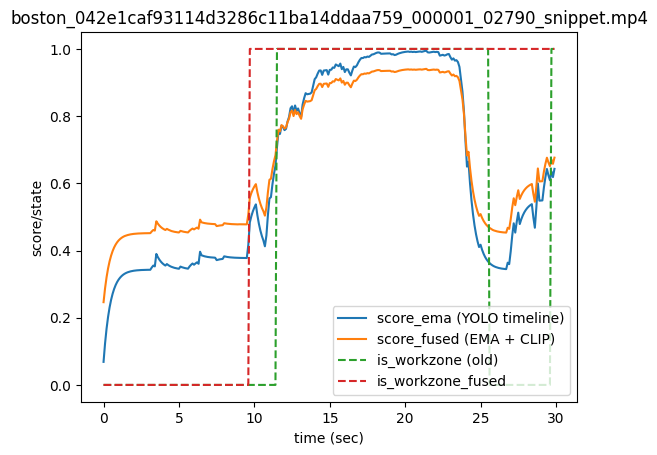

In [45]:
# Plot flicker reduction

import matplotlib.pyplot as plt

def plot_timeline(df, title=""):
    x = df["time_sec"].values
    plt.figure()
    plt.plot(x, df["score_ema"].values, label="score_ema (YOLO timeline)")
    plt.plot(x, df["score_fused"].values, label="score_fused (EMA + CLIP)")
    plt.plot(x, df["is_workzone"].values, label="is_workzone (old)", linestyle="--")
    plt.plot(x, df["is_workzone_fused"].values, label="is_workzone_fused", linestyle="--")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("time (sec)")
    plt.ylabel("score/state")
    plt.title(title)
    plt.legend()
    plt.show()

plot_timeline(df_out, title=vpath.name)


In [46]:
# Batch mode

def run_notebook6_batch(timeline_csvs, max_videos=10):
    out_index = []
    for timeline_csv in tqdm(timeline_csvs[:max_videos], desc="Notebook6 batch"):
        try:
            df_out, df_sem, vpath = run_semantics_on_one_video(timeline_csv, every_n_frames=30)
            out_index.append({
                "video": vpath.name,
                "timeline_csv": str(timeline_csv),
                "fused_timeline": str(OUT_DIR / (timeline_csv.stem.replace("_timeline","") + "_timeline_fused.csv")),
                "semantics_csv": str(OUT_DIR / (timeline_csv.stem.replace("_timeline","") + "_semantics.csv")),
                "frames": int(len(df_out)),
                "num_triggers": int(len(df_sem)),
            })
        except Exception as e:
            out_index.append({"video": timeline_csv.stem, "error": str(e)})

    df_index = pd.DataFrame(out_index)
    outp = OUT_DIR / "notebook6_outputs_index.csv"
    df_index.to_csv(outp, index=False)
    print("Saved index:", outp)
    return df_index

df_index = run_notebook6_batch(timeline_csvs, max_videos=20)
df_index.head()


VLM triggers: boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet.mp4: 
Notebook6 batch:   5%|█▎                         | 1/20 [00:06<02:08,  6.77s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_02790_snippet_timeline_fused.csv


VLM triggers: boston_042e1caf93114d3286c11ba14ddaa759_000001_13410_snippet.mp4: 
Notebook6 batch:  10%|██▋                        | 2/20 [00:14<02:13,  7.43s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_13410_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_042e1caf93114d3286c11ba14ddaa759_000001_13410_snippet_timeline_fused.csv


VLM triggers: boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_08460_snippet.mp4: 
Notebook6 batch:  15%|████                       | 3/20 [00:22<02:11,  7.75s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_08460_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_08460_snippet_timeline_fused.csv


VLM triggers: boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_11610_snippet.mp4: 
Notebook6 batch:  20%|█████▍                     | 4/20 [00:30<02:03,  7.72s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_11610_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000_11610_snippet_timeline_fused.csv


VLM triggers: boston_10cb4a5e9c0740c8a6ff092bae0d4873_000001_22890_snippet.mp4: 
Notebook6 batch:  25%|██████▊                    | 5/20 [00:36<01:45,  7.02s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000001_22890_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000001_22890_snippet_timeline_fused.csv


VLM triggers: boston_10cb4a5e9c0740c8a6ff092bae0d4873_000003_00150_snippet.mp4: 
Notebook6 batch:  30%|████████                   | 6/20 [00:40<01:23,  5.98s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000003_00150_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000003_00150_snippet_timeline_fused.csv


VLM triggers: boston_10cb4a5e9c0740c8a6ff092bae0d4873_000004_00810_snippet.mp4: 
Notebook6 batch:  35%|█████████▍                 | 7/20 [00:46<01:19,  6.09s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000004_00810_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_10cb4a5e9c0740c8a6ff092bae0d4873_000004_00810_snippet_timeline_fused.csv


VLM triggers: boston_2bdb5a72602342a5991b402beb8b7ab4_000001_23370_snippet.mp4: 
Notebook6 batch:  40%|██████████▊                | 8/20 [00:53<01:16,  6.34s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2bdb5a72602342a5991b402beb8b7ab4_000001_23370_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2bdb5a72602342a5991b402beb8b7ab4_000001_23370_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000004_04710_snippet.mp4: 
Notebook6 batch:  45%|████████████▏              | 9/20 [00:58<01:04,  5.88s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000004_04710_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000004_04710_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000006_01530_snippet.mp4: 
Notebook6 batch:  50%|█████████████             | 10/20 [01:04<00:58,  5.90s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000006_01530_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000006_01530_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000008_09810_snippet.mp4: 
Notebook6 batch:  55%|██████████████▎           | 11/20 [01:10<00:53,  5.96s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000008_09810_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000008_09810_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000009_02250_snippet.mp4: 
Notebook6 batch:  60%|███████████████▌          | 12/20 [01:15<00:45,  5.68s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000009_02250_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000009_02250_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000010_05160_snippet.mp4: 
Notebook6 batch:  65%|████████████████▉         | 13/20 [01:20<00:38,  5.49s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000010_05160_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000010_05160_snippet_timeline_fused.csv


VLM triggers: boston_2d8e13b1a8304d8395dcf6479ca61814_000010_07500_snippet.mp4: 
Notebook6 batch:  70%|██████████████████▏       | 14/20 [01:24<00:30,  5.07s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000010_07500_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2d8e13b1a8304d8395dcf6479ca61814_000010_07500_snippet_timeline_fused.csv


VLM triggers: boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_02220_snippet.mp4: 
Notebook6 batch:  75%|███████████████████▌      | 15/20 [01:32<00:29,  5.81s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_02220_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_02220_snippet_timeline_fused.csv


VLM triggers: boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_04560_snippet.mp4: 
Notebook6 batch:  80%|████████████████████▊     | 16/20 [01:39<00:25,  6.39s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_04560_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_04560_snippet_timeline_fused.csv


VLM triggers: boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_05820_snippet.mp4: 
Notebook6 batch:  85%|██████████████████████    | 17/20 [01:44<00:18,  6.01s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_05820_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_05820_snippet_timeline_fused.csv


VLM triggers: boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_11100_snippet.mp4: 
Notebook6 batch:  90%|███████████████████████▍  | 18/20 [01:52<00:12,  6.45s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_11100_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_11100_snippet_timeline_fused.csv


VLM triggers: boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_16290_snippet.mp4: 
Notebook6 batch:  95%|████████████████████████▋ | 19/20 [02:01<00:07,  7.16s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_16290_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_2dacdcbcc3bf42c28eeb08592fc2c325_000002_16290_snippet_timeline_fused.csv


VLM triggers: boston_344db257af864142a18c582228d2920a_000001_11040_snippet.mp4: 
Notebook6 batch: 100%|██████████████████████████| 20/20 [02:08<00:00,  6.45s/it]

Saved semantics: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_344db257af864142a18c582228d2920a_000001_11040_snippet_semantics.csv
Saved fused timeline: /data/wesleyferreiramaia/workzone/outputs/notebook6/boston_344db257af864142a18c582228d2920a_000001_11040_snippet_timeline_fused.csv
Saved index: /data/wesleyferreiramaia/workzone/outputs/notebook6/notebook6_outputs_index.csv


,video,timeline_csv,fused_timeline,semantics_csv,frames,num_triggers
0,boston_042e1caf93114d3286c11ba14ddaa759_000001...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,300,16
1,boston_042e1caf93114d3286c11ba14ddaa759_000001...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,300,16
2,boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,300,17
3,boston_10cb4a5e9c0740c8a6ff092bae0d4873_000000...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,300,15
4,boston_10cb4a5e9c0740c8a6ff092bae0d4873_000001...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,/data/wesleyferreiramaia/workzone/outputs/note...,301,13
